In [1]:
%pip install wbdata

import wbdata

Note: you may need to restart the kernel to use updated packages.


Key '4554893263572836092' not in persistent cache.


In [5]:
import wbdata

# Return list of all country/region codes:
wbdata.get_countries()


id    name
----  --------------------------------------------------------------------------------
ABW   Aruba
AFE   Africa Eastern and Southern
AFG   Afghanistan
AFR   Africa
AFW   Africa Western and Central
AGO   Angola
ALB   Albania
AND   Andorra
ARB   Arab World
ARE   United Arab Emirates
ARG   Argentina
ARM   Armenia
ASM   American Samoa
ATG   Antigua and Barbuda
AUS   Australia
AUT   Austria
AZE   Azerbaijan
BDI   Burundi
BEA   East Asia & Pacific (IBRD-only countries)
BEC   Europe & Central Asia (IBRD-only countries)
BEL   Belgium
BEN   Benin
BFA   Burkina Faso
BGD   Bangladesh
BGR   Bulgaria
BHI   IBRD countries classified as high income
BHR   Bahrain
BHS   Bahamas, The
BIH   Bosnia and Herzegovina
BLA   Latin America & the Caribbean (IBRD-only countries)
BLR   Belarus
BLZ   Belize
BMN   Middle East, North Africa, Afghanistan & Pakistan (IBRD only)
BMU   Bermuda
BOL   Bolivia
BRA   Brazil
BRB   Barbados
BRN   Brunei Darussalam
BSS   Sub-Saharan Africa (IBRD-only countries)
BTN  

In [8]:
SOURCE = 40 # "Population estimates and projections

indicators = wbdata.get_indicators(source=SOURCE)
indicators

id                 name
-----------------  -------------------------------------------------------------------
SH.DTH.0509        Number of deaths ages 5-9 years
SH.DTH.0514        Number of deaths ages 5-14 years
SH.DTH.1014        Number of deaths ages 10-14 years
SH.DTH.1019        Number of deaths ages 10-19 years
SH.DTH.1519        Number of deaths ages 15-19 years
SH.DTH.2024        Number of deaths ages 20-24 years
SH.DTH.IMRT        Number of infant deaths
SH.DTH.IMRT.FE     Number of infant deaths, female
SH.DTH.IMRT.MA     Number of infant deaths, male
SH.DTH.MORT        Number of under-five deaths
SH.DTH.MORT.FE     Number of under-five deaths, female
SH.DTH.MORT.MA     Number of under-five deaths, male
SH.DTH.NMRT        Number of neonatal deaths
SH.DYN.0509        Probability of dying among children ages 5-9 years (per 1,000)
SH.DYN.0514        Probability of dying at age 5-14 years (per 1,000 children age 5)
SH.DYN.1014        Probability of dying among adolescents ages 1

In [22]:
import logging
logging.getLogger('shelved_cache').setLevel(logging.ERROR)

In [23]:
def population(year=2020, sex="People", age_range=(0, 100), place="USA"):
    """
    Returns the population count.
    If sex is 'People', it sums Male + Female automatically.
    """
    
    # --- STRATEGY: Recursion for 'People' ---
    # The World Bank often misses 'Total' codes for specific ages.
    # So we calculate it: People = Male + Female
    if sex == "People":
        males = population(year, "Male", age_range, place)
        females = population(year, "Female", age_range, place)
        return males + females

    # --- 1. Set up the Gender Suffix ---
    # We only handle Male/Female here because 'People' is handled above
    if sex == "Male":
        suffix = ".MA"
    elif sex == "Female":
        suffix = ".FE"
    else:
        return 0 # Safety catch
        
    # --- 2. Map Ages to World Bank Codes ---
    # Logic: Start Age -> Code Middle (e.g., 0 -> "0004")
    ages = {
        0: "0004", 5: "0509", 10: "1014", 15: "1519", 20: "2024",
        25: "2529", 30: "3034", 35: "3539", 40: "4044", 45: "4549",
        50: "5054", 55: "5559", 60: "6064", 65: "6569", 70: "7074",
        75: "7579", 80: "80UP"
    }
    
    # --- 3. Build the Request List ---
    variable_labels = {}
    low, high = age_range
    
    for start_age in ages:
        # Check if this bucket is inside our range
        if start_age >= low and start_age < high:
            # Code format: SP.POP + AGE + SUFFIX
            code = "SP.POP." + ages[start_age] + suffix
            variable_labels[code] = "Count"
            
    # If the range was weird (like 22-23) and we found no buckets, return 0
    if not variable_labels:
        return 0

    # --- 4. Fetch Data ---
    # We use source=2 (WDI) to be safe, though wbdata usually guesses right
    df = wbdata.get_dataframe(variable_labels, country=place)
    
    # Clean up dates (convert string "2020" to int 2020)
    df.index = df.index.astype(int)
    
    # Return the sum for that year
    # We use .get() to avoid crashing if the year is missing
    try:
        return int(df.loc[year].sum())
    except KeyError:
        return 0

In [24]:
print(population())

12043345


In [29]:
def population_dataframe(place="WLD"):
    """
    Returns a DataFrame indexed by Country and Year.
    Robust version: Handles single-country and multi-country queries safely.
    """
    
    # --- 1. Build the dictionary (Same as before) ---
    variable_labels = {}
    ages = {
        0: "0004", 5: "0509", 10: "1014", 15: "1519", 20: "2024",
        25: "2529", 30: "3034", 35: "3539", 40: "4044", 45: "4549",
        50: "5054", 55: "5559", 60: "6064", 65: "6569", 70: "7074",
        75: "7579", 80: "80UP"
    }
    
    for sex, suffix in [("Male", ".MA"), ("Female", ".FE")]:
        for start_age, code_mid in ages.items():
            wb_code = "SP.POP." + code_mid + suffix
            end_age = start_age + 4
            if start_age == 80: end_age = "UP"
            human_name = f"{sex} {start_age}-{end_age}"
            variable_labels[wb_code] = human_name

    # --- 2. Fetch the data ---
    df = wbdata.get_dataframe(variable_labels, country=place)
    
    # --- 3. Clean up the Index (The Fixed Part) ---
    # Pull the index (Date, and maybe Country) into regular columns
    df = df.reset_index()
    
    # FIX A: Force all column names to lowercase 
    # (Solves issues where wbdata returns 'Country' instead of 'country')
    df.columns = [c.lower() for c in df.columns]
    
    # FIX B: If 'country' is missing (happens with single-country queries), add it back
    if 'country' not in df.columns:
        # If place is a list ["USA"], take "USA". If it's a string "USA", take "USA".
        country_name = place[0] if isinstance(place, list) else place
        df['country'] = country_name

    # Convert date to integer
    df['date'] = df['date'].astype(int)
    
    # Now it's safe to set the index
    return df.set_index(['country', 'date']).sort_index()

# --- Test it again ---
# This triggered the error before, but now it should work!
my_table = population_dataframe(["USA"])
my_table.head()

male 0-4    male 5-9  male 10-14  male 15-19  male 20-24  \
country date                                                               
USA     1960  10473733.0   9469983.0   8558604.0   6665633.0   5449313.0   
        1961  10593131.0   9701604.0   8828155.0   7029097.0   5530848.0   
        1962  10627691.0   9913698.0   8936967.0   7460189.0   5733953.0   
        1963  10570520.0  10103543.0   9074835.0   7819480.0   6021953.0   
        1964  10459170.0  10249046.0   9300147.0   8148503.0   6333571.0   

              male 25-29  male 30-34  male 35-39  male 40-44  male 45-49  ...  \
country date                                                              ...   
USA     1960   5454634.0   5917690.0   6133655.0   5761578.0   5351148.0  ...   
        1961   5424644.0   5861753.0   6099786.0   5858050.0   5389377.0  ...   
        1962   5444865.0   5773411.0   6058050.0   5942645.0   5427460.0  ...   
        1963   5505468.0   5675452.0   6018197.0   5995989.0   5475396.0  ...   
        1964   5553325.0   5601640.0   5959860.0   6028640.0   5527623.0  ...   

              female 35-39  female 40-44  female 45-49  female 50-54  \
country date                                                           
USA     1960     6448622.0     5996765.0     5526571.0     4978256.0   
        1961     6435681.0     6110752.0     5606259.0     5058400.0   
        1962     6381515.0     6235312.0     5666291.0     5134822.0   
        1963     6320355.0     6316766.0     5737014.0     5210866.0   
        1964     6236223.0     6367738.0     5822237.0     5295201.0   

              female 55-59  female 60-64  female 65-69  female 70-74  \
country date                                                           
USA     1960     4360599.0     3784407.0     3224374.0     2484070.0   
        1961     4414794.0     3869632.0     3301056.0     2540627.0   
        1962     4518772.0     3928469.0     3345904.0     2613176.0   
        1963     4626679.0     3994968.0     3376889.0     2690358.0   
        1964     4722042.0     4072070.0     3410175.0     2760969.0   

              female 75-79  female 80-up  
country date                              
USA     1960     1658405.0     1442210.0  
        1961     1731634.0     1527529.0  
        1962     1797338.0     1612447.0  
        1963     1866589.0     1692646.0  
        1964     1933637.0     1782325.0  

[5 rows x 34 columns]

In [33]:
# 1. Create a "Translator" dictionary
# This maps the weird computer codes to the names the graph expects
translator = {}
ages = {
    0: "0004", 5: "0509", 10: "1014", 15: "1519", 20: "2024",
    25: "2529", 30: "3034", 35: "3539", 40: "4044", 45: "4549",
    50: "5054", 55: "5559", 60: "6064", 65: "6569", 70: "7074",
    75: "7579", 80: "80UP"
}

# Build the map for both genders
for sex, suffix in [("Male", ".MA"), ("Female", ".FE")]:
    for start, code_mid in ages.items():
        weird_code = f"SP.POP.{code_mid}{suffix}"
        
        # We need it to match the graph's expectation: "Male 0-4"
        end_age = start + 4
        
        # Handle the 80+ special case to match the graph code
        if start == 80:
            nice_name = f"{sex} 80UP" 
        else:
            nice_name = f"{sex} {start}-{end_age}"
            
        translator[weird_code] = nice_name

# 2. Rename the columns in your table
# errors='ignore' ensures it doesn't crash if a column is missing
my_table = my_table.rename(columns=translator)

# 3. Check if it worked
print("New columns:", my_table.columns[:5])

New columns: Index(['male 0-4', 'male 5-9', 'male 10-14', 'male 15-19', 'male 20-24'], dtype='object')


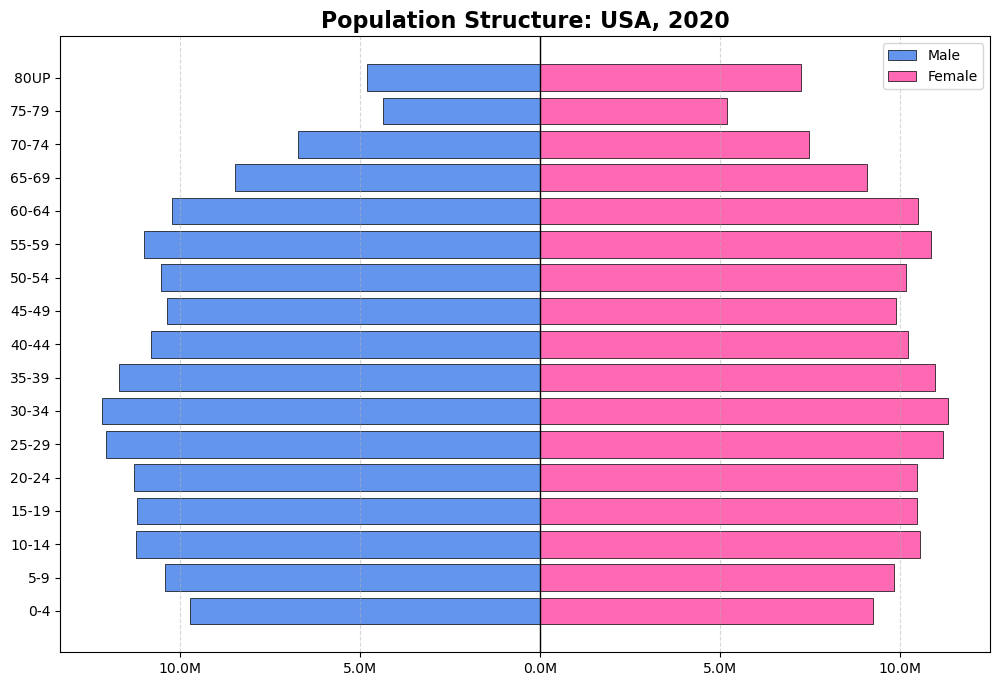

In [40]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def plot_pyramid_pretty(df, year, country):
    # 1. Get Data (Same as before)
    try:
        row = df.loc[(country, year)]
    except KeyError:
        print("No data found.")
        return

    age_groups = [
        "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34",
        "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", 
        "65-69", "70-74", "75-79", "80UP"
    ]
    
    # 2. Extract Data
    males = [row[f"Male {age}"] for age in age_groups]
    females = [row[f"Female {age}"] for age in age_groups]
    
    # 3. Setup the Graph
    fig, ax = plt.subplots(figsize=(12, 8)) # Bigger size
    y_pos = range(len(age_groups))
    
    # 4. Draw Bars with Nice Colors
    # cornflowerblue & hotpink are standard "pretty" gender colors in data viz
    ax.barh(y_pos, [-m for m in males], color='cornflowerblue', label='Male', edgecolor='black', linewidth=0.5)
    ax.barh(y_pos, females, color='hotpink', label='Female', edgecolor='black', linewidth=0.5)
    
    # 5. Beautify the Layout
    ax.set_yticks(y_pos)
    ax.set_yticklabels(age_groups, fontsize=10)
    ax.set_title(f"Population Structure: {country}, {year}", fontsize=16, fontweight='bold')
    ax.legend(loc='upper right', frameon=True)
    
    # Add a grid behind the bars (makes it easier to read)
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)
    
    # 6. The "Magic" Formatter for the X-Axis
    # This turns "2000000" into "2M" and "-2000000" into "2M"
    def millions(x, pos):
        return f'{abs(x)/1_000_000:.1f}M'
        
    ax.xaxis.set_major_formatter(FuncFormatter(millions))
    
    # Add a vertical line at 0 to separate the sides
    ax.axvline(0, color='black', linewidth=1)
    
    plt.show()

# Run the pretty version
plot_pyramid_pretty(final_df, 2020, "USA")